# Legal Contract Clause Classification using Stacked LSTM
## CCS 248 – Artificial Neural Networks Final Project
---

## Problem Statement

**Automated Classification of Legal Contract Clauses**

Lawyers spend hours manually reading and categorizing individual contract clauses (e.g., governing law, termination, confidentiality). This project automates that process using deep learning to classify each clause context into predefined legal categories.

## Dataset

**CUAD v1 master_clauses.csv** (flattened clause snippets)
- Filtered to top 20 clause types

## Target

**Test Accuracy: 50-60%** (course requirement)

**Evaluation**: Accuracy, macro F1, per-class precision/recall, confusion matrix

# 1. Setup

In [1]:
# Core data processing libraries
import numpy as np
import pandas as pd
import json
import os
import re
import ast
from datetime import datetime
from collections import Counter

# Text processing
import string
from typing import List, Dict, Tuple

# PyTorch for deep learning (avoid Keras)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Scikit-learn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Display versions
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Using device: {device}")

PyTorch Version: 2.9.1+cpu
NumPy Version: 2.1.3
Pandas Version: 2.2.3
Using device: cpu


# 2. Load Data

In [2]:
# Load clause snippets from CUAD XLSX sheets (label_group_xlsx)
import glob
XLSX_DIR = r"D:\CodingRelated\Codes.Ams\ANNFINAL\CUAD_v1\label_group_xlsx"
print(f"Loading XLSX files from: {XLSX_DIR}")

def load_xlsx_snippets(xlsx_dir: str):
    rows = []
    files = glob.glob(os.path.join(xlsx_dir, "*.xlsx"))
    if not files:
        raise FileNotFoundError(f"No .xlsx files found in {xlsx_dir}")
    for path in files:
        df_x = pd.read_excel(path)
        if df_x.empty:
            continue
        clause_cols = [c for c in df_x.columns if c != df_x.columns[0]]
        for _, row in df_x.iterrows():
            for col in clause_cols:
                text = row[col]
                if pd.isna(text):
                    continue
                text = str(text).strip()
                if not text:
                    continue
                rows.append({"context": text, "clause_type": col})
    df_out = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)
    return df_out, len(files)

df, n_files = load_xlsx_snippets(XLSX_DIR)
print(f"✓ Loaded {len(df)} snippets from {n_files} XLSX files")
print(f"Unique clause types: {df['clause_type'].nunique()}")

Loading XLSX files from: D:\CodingRelated\Codes.Ams\ANNFINAL\CUAD_v1\label_group_xlsx
✓ Loaded 8035 snippets from 28 XLSX files
Unique clause types: 47


In [3]:
# Basic dataset overview
print(df.head())
print("\nTop clause counts:")
print(df['clause_type'].value_counts().head(15))

                                             context        clause_type
0  MA may not assign, sell, lease or otherwise tr...    Anti-assignment
1  This Agreement may not be assigned, sold or tr...    Anti-assignment
2  For purposes of the preceding sentence, and wi...  Change of Control
3  Licensee shall not assign or otherwise transfe...    Anti-assignment
4  Licensee shall have the right to assign or sub...    Anti-assignment

Top clause counts:
clause_type
Parties                      505
Parties-Answer               499
Agreement Date               464
Governing Law                435
Agreement Date-Answer        424
Expiration Date              411
Effective Date               384
Anti-assignment              372
Effective Date-Answer        328
Document Name                311
Cap on Liability             275
License Grant                254
Expiration Date-Answer       249
Audit Rights                 214
Post-termination Services    182
Name: count, dtype: int64


In [4]:
# Dataset stats
print(f"Total snippets: {len(df)}")
print(f"Unique clause types: {df['clause_type'].nunique()}")
print(f"Average length (words): {df['context'].apply(lambda x: len(str(x).split())).mean():.1f}")

Total snippets: 8035
Unique clause types: 47
Average length (words): 74.6


In [5]:
# Display first few rows
print("\n" + "="*80)
print("First 5 Rows of Dataset:")
print("="*80)
print(df.head())

# Display basic statistics
print("\n" + "="*80)
print("Dataset Info:")
print("="*80)
print(df.info())


First 5 Rows of Dataset:
                                             context        clause_type
0  MA may not assign, sell, lease or otherwise tr...    Anti-assignment
1  This Agreement may not be assigned, sold or tr...    Anti-assignment
2  For purposes of the preceding sentence, and wi...  Change of Control
3  Licensee shall not assign or otherwise transfe...    Anti-assignment
4  Licensee shall have the right to assign or sub...    Anti-assignment

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   context      8035 non-null   object
 1   clause_type  8035 non-null   object
dtypes: object(2)
memory usage: 125.7+ KB
None


## 2.1 Data Distribution Visualizations

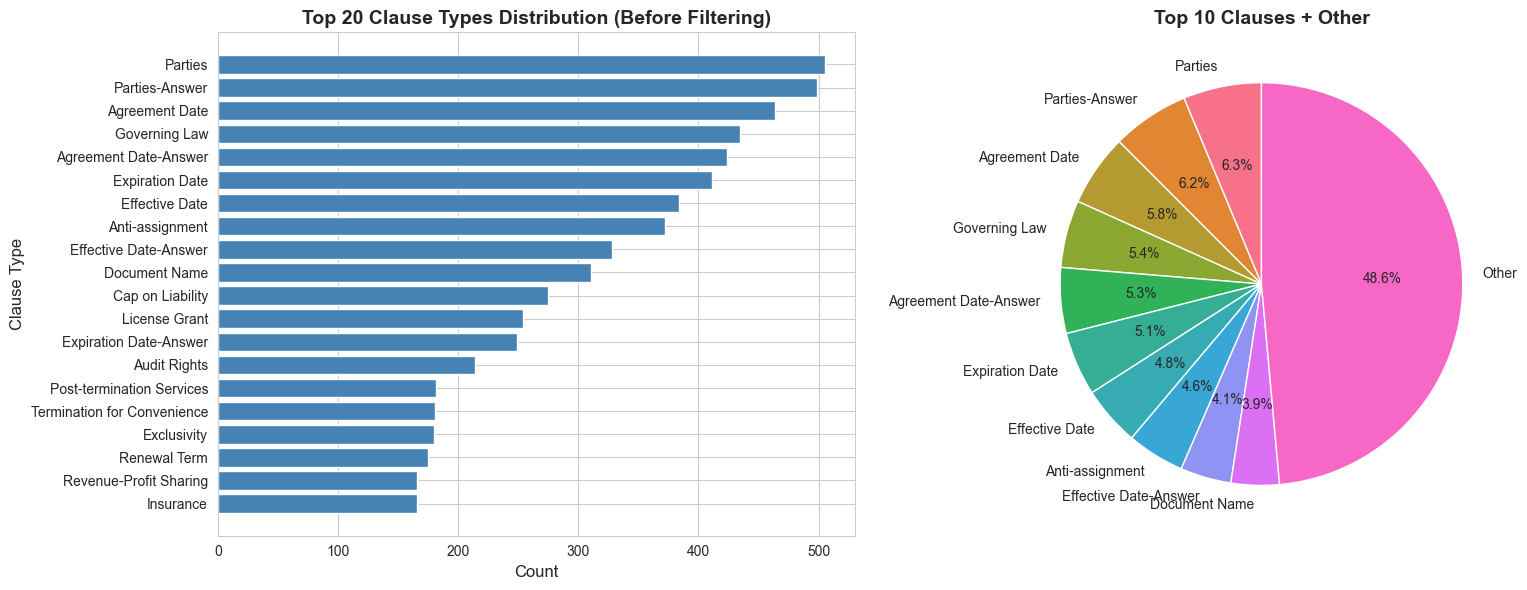


Total clause types: 47
Most common: Parties (505 samples)


In [6]:
# Visualize clause type distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of clause counts
clause_counts = df['clause_type'].value_counts()
axes[0].barh(clause_counts.index[:20], clause_counts.values[:20], color='steelblue')
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Clause Type', fontsize=12)
axes[0].set_title('Top 20 Clause Types Distribution (Before Filtering)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Pie chart for proportions
top_n = 10
top_clauses = clause_counts.head(top_n)
other_sum = clause_counts.iloc[top_n:].sum()
pie_data = pd.concat([top_clauses, pd.Series({'Other': other_sum})])
colors = sns.color_palette('husl', len(pie_data))
axes[1].pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title(f'Top {top_n} Clauses + Other', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal clause types: {len(clause_counts)}")
print(f"Most common: {clause_counts.index[0]} ({clause_counts.values[0]} samples)")

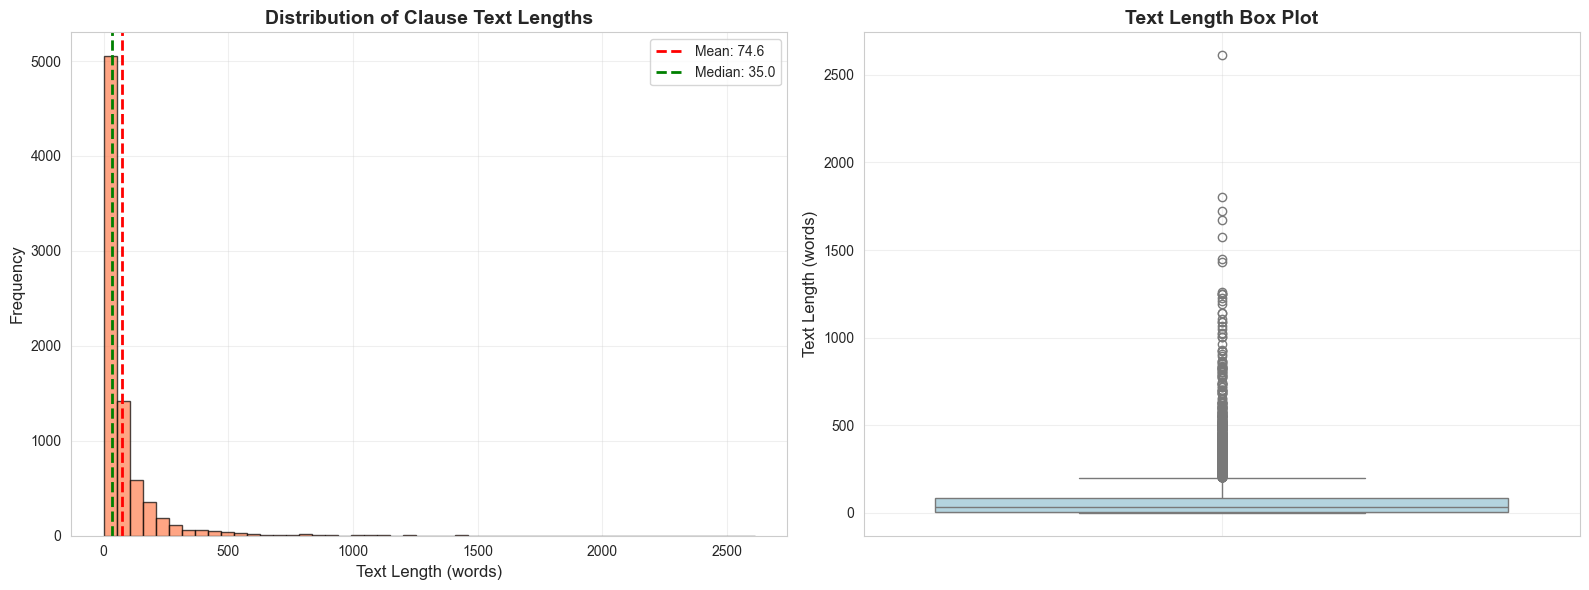


Text Length Statistics:
Mean: 74.59 words
Median: 35.00 words
Min: 1 words
Max: 2612 words
Std: 129.89 words


In [7]:
# Text length distribution analysis
df['text_length'] = df['context'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of text lengths
axes[0].hist(df['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["text_length"].mean():.1f}')
axes[0].axvline(df['text_length'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["text_length"].median():.1f}')
axes[0].set_xlabel('Text Length (words)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Clause Text Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot of text lengths
sns.boxplot(data=df, y='text_length', ax=axes[1], color='lightblue')
axes[1].set_ylabel('Text Length (words)', fontsize=12)
axes[1].set_title('Text Length Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nText Length Statistics:")
print(f"Mean: {df['text_length'].mean():.2f} words")
print(f"Median: {df['text_length'].median():.2f} words")
print(f"Min: {df['text_length'].min()} words")
print(f"Max: {df['text_length'].max()} words")
print(f"Std: {df['text_length'].std():.2f} words")

# 3. Data Validation

In [8]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

print(f"\nTotal samples: {len(df)}")

Missing values:
context        0
clause_type    0
text_length    0
dtype: int64

Total samples: 8035


In [9]:
# Check class distribution
print("Top 10 clause types:")
print(df['clause_type'].value_counts().head(10))

Top 10 clause types:
clause_type
Parties                  505
Parties-Answer           499
Agreement Date           464
Governing Law            435
Agreement Date-Answer    424
Expiration Date          411
Effective Date           384
Anti-assignment          372
Effective Date-Answer    328
Document Name            311
Name: count, dtype: int64


# 4. Preprocessing

In [10]:
def clean_text(text):
    """Basic text cleaning"""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-z\s\.,;:\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Test
sample = "THIS AGREEMENT is made on January 1, 2020!!!"
print("Before:", sample)
print("After:", clean_text(sample))

Before: THIS AGREEMENT is made on January 1, 2020!!!
After: this agreement is made on january ,


In [11]:
# Apply cleaning
df['cleaned_text'] = df['context'].apply(clean_text)
print("✓ Cleaned all documents")

✓ Cleaned all documents


# 5. Text Length Analysis

In [12]:
# Use cleaned text directly (clause contexts are already short)
df['sampled_text'] = df['cleaned_text']
print(f"✓ Using {len(df)} clause contexts (no truncation needed)")

✓ Using 8035 clause contexts (no truncation needed)


# 6. Tokenization

In [13]:
class CustomTokenizer:
    """Simple tokenizer - built from scratch"""
    
    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        self.word_to_index = {"<OOV>": 1}
        self.word_counts = Counter()
        
    def fit_on_texts(self, texts):
        for text in texts:
            self.word_counts.update(str(text).split())
        
        most_common = self.word_counts.most_common(self.vocab_size - 2)
        for idx, (word, _) in enumerate(most_common, start=2):
            self.word_to_index[word] = idx
        
        print(f"Vocabulary size: {len(self.word_to_index)}")
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            seq = [self.word_to_index.get(word, 1) for word in str(text).split()]
            sequences.append(seq)
        return sequences
    
    def get_vocab_size(self):
        return len(self.word_to_index)

# Tokenizer will be built after filtering to top clauses

# 7. Prepare Data for Training

In [14]:
def pad_sequences(sequences, maxlen, padding='post', value=0):
    """Pad sequences to the same length"""
    padded = np.zeros((len(sequences), maxlen), dtype=np.int32)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            if padding == 'post':
                padded[i] = seq[:maxlen]
            else:
                padded[i] = seq[-maxlen:]
        else:
            if padding == 'post':
                padded[i, :len(seq)] = seq
            else:
                padded[i, -len(seq):] = seq
    return padded

In [15]:
# Select clause types with enough support to stratify
TOP_N = 20
MIN_COUNT = 5
clause_counts = df['clause_type'].value_counts()
filtered_counts = clause_counts[clause_counts >= MIN_COUNT]
top_clauses = filtered_counts.head(TOP_N).index.tolist()
df_filtered = df[df['clause_type'].isin(top_clauses)].copy()

print(f"Using {len(df_filtered)} samples before augmentation")
print(f"Top clause types (min {MIN_COUNT} per class):")
for i, (clause, count) in enumerate(filtered_counts.head(TOP_N).items(), 1):
    print(f"  {i}. {clause[:80]}... ({count} samples)")

ENABLE_AUGMENTATION = True
TARGET_MIN_PER_CLASS = 200  # desired minimum rows per class after augmentation
REPLACE_PROB = 0.25        # probability of replacing a token with a synonym
MAX_AUG_PER_CLASS = 300     # cap to avoid explosion per class

if ENABLE_AUGMENTATION:
    import random
    try:
        import nltk
        from nltk.corpus import wordnet as wn
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
    except Exception as e:
        wn = None
        print(f"NLTK/wordnet not available, skipping synonym augmentation: {e}")

    def get_synonyms(word):
        if wn is None:
            return []
        syns = set()
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                candidate = lemma.name().replace('_', ' ').lower()
                if candidate.isalpha() and candidate != word.lower():
                    syns.add(candidate)
        return list(syns)

    def synonym_replace(text, replace_prob=0.2):
        tokens = str(text).split()
        new_tokens = []
        for tok in tokens:
            if random.random() < replace_prob:
                syns = get_synonyms(tok)
                if syns:
                    new_tokens.append(random.choice(syns))
                    continue
            new_tokens.append(tok)
        return " ".join(new_tokens)

    aug_rows = []
    for label, group in df_filtered.groupby('clause_type'):
        current_count = len(group)
        if current_count >= TARGET_MIN_PER_CLASS:
            continue
        needed = min(TARGET_MIN_PER_CLASS - current_count, MAX_AUG_PER_CLASS)
        pool = group['sampled_text'].tolist()
        for i in range(needed):
            base_text = pool[i % len(pool)]
            aug_text = synonym_replace(base_text, replace_prob=REPLACE_PROB)
            aug_rows.append({
                'context': aug_text,
                'clause_type': label,
                'cleaned_text': aug_text,
                'sampled_text': aug_text,
            })

    if aug_rows:
        df_aug = pd.DataFrame(aug_rows)
        df_filtered = pd.concat([df_filtered, df_aug], ignore_index=True)
        print(f"Applied augmentation: +{len(aug_rows)} synthetic rows")
    else:
        print("No augmentation applied (all classes already above target or wordnet unavailable)")

print(f"Total samples after augmentation: {len(df_filtered)}")

# Build tokenizer on filtered (and possibly augmented) data with smaller vocab to limit noise
tokenizer = CustomTokenizer(vocab_size=10000)
tokenizer.fit_on_texts(df_filtered['sampled_text'])

# Tokenize filtered data
sequences_filtered = tokenizer.texts_to_sequences(df_filtered['sampled_text'])

# Length stats and padding length
sequence_lengths = [len(seq) for seq in sequences_filtered]
percentile_len = int(np.percentile(sequence_lengths, 85))
MAX_LENGTH = min(percentile_len, 160)
print(f"Sequence length percentile(85th): {percentile_len}")
print(f"Max sequence length used: {MAX_LENGTH} (capped at 160)")

# Pad filtered sequences
X_filtered = pad_sequences(sequences_filtered, maxlen=MAX_LENGTH, padding='post')
print(f"Padded shape (filtered): {X_filtered.shape}")

Using 6175 samples before augmentation
Top clause types (min 5 per class):
  1. Parties... (505 samples)
  2. Parties-Answer... (499 samples)
  3. Agreement Date... (464 samples)
  4. Governing Law... (435 samples)
  5. Agreement Date-Answer... (424 samples)
  6. Expiration Date... (411 samples)
  7. Effective Date... (384 samples)
  8. Anti-assignment... (372 samples)
  9. Effective Date-Answer... (328 samples)
  10. Document Name... (311 samples)
  11. Cap on Liability... (275 samples)
  12. License Grant... (254 samples)
  13. Expiration Date-Answer... (249 samples)
  14. Audit Rights... (214 samples)
  15. Post-termination Services... (182 samples)
  16. Termination for Convenience... (181 samples)
  17. Exclusivity... (180 samples)
  18. Renewal Term... (175 samples)
  19. Revenue-Profit Sharing... (166 samples)
  20. Insurance... (166 samples)
Applied augmentation: +150 synthetic rows
Total samples after augmentation: 6325
Vocabulary size: 9999
Sequence length percentile(85th): 1

In [16]:
# Diagnostic: OOV rate on filtered sequences
# OOV token id is 1 in the tokenizer
all_tokens = sum(len(seq) for seq in sequences_filtered)
oov_tokens = sum(sum(1 for t in seq if t == 1) for seq in sequences_filtered)
oov_pct = 100 * oov_tokens / max(1, all_tokens)
print(f"OOV tokens: {oov_tokens} / {all_tokens} ({oov_pct:.2f}%)")

OOV tokens: 2337 / 368377 (0.63%)


In [17]:
# Encode labels after filtering
df_filtered = df_filtered.reset_index(drop=True)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_filtered['clause_type'])
num_classes = len(label_encoder.classes_)
print(f"Labels shape: {y_encoded.shape}")
print(f"Classes: {label_encoder.classes_}")

Labels shape: (6325,)
Classes: ['Agreement Date' 'Agreement Date-Answer' 'Anti-assignment' 'Audit Rights'
 'Cap on Liability' 'Document Name' 'Effective Date'
 'Effective Date-Answer' 'Exclusivity' 'Expiration Date'
 'Expiration Date-Answer' 'Governing Law' 'Insurance' 'License Grant'
 'Parties' 'Parties-Answer' 'Post-termination Services' 'Renewal Term'
 'Revenue-Profit Sharing' 'Termination for Convenience']


## 7.1 Filtered Dataset Visualizations

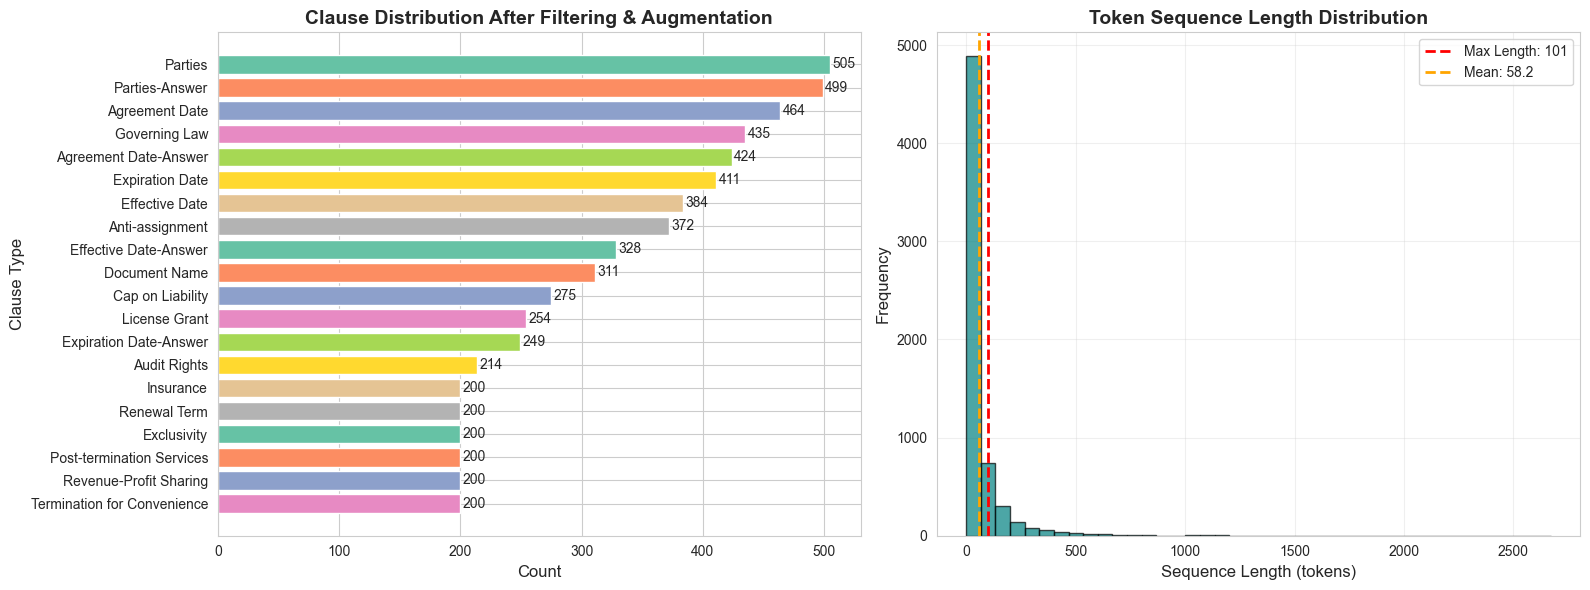


Filtered dataset statistics:
Number of classes: 20
Total samples: 6325
Min samples per class: 200
Max samples per class: 505
Mean samples per class: 316.2


In [18]:
# Visualize filtered class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot after filtering
filtered_counts = df_filtered['clause_type'].value_counts()
colors_bar = sns.color_palette('Set2', len(filtered_counts))
axes[0].barh(filtered_counts.index, filtered_counts.values, color=colors_bar)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Clause Type', fontsize=12)
axes[0].set_title('Clause Distribution After Filtering & Augmentation', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add count labels on bars
for i, (idx, val) in enumerate(filtered_counts.items()):
    axes[0].text(val + 2, i, str(val), va='center', fontsize=10)

# Sequence length distribution
seq_lens = [len(seq) for seq in sequences_filtered]
axes[1].hist(seq_lens, bins=40, color='teal', edgecolor='black', alpha=0.7)
axes[1].axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length: {MAX_LENGTH}')
axes[1].axvline(np.mean(seq_lens), color='orange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(seq_lens):.1f}')
axes[1].set_xlabel('Sequence Length (tokens)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Token Sequence Length Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFiltered dataset statistics:")
print(f"Number of classes: {len(filtered_counts)}")
print(f"Total samples: {len(df_filtered)}")
print(f"Min samples per class: {filtered_counts.min()}")
print(f"Max samples per class: {filtered_counts.max()}")
print(f"Mean samples per class: {filtered_counts.mean():.1f}")

In [19]:
# TF-IDF + Logistic Regression baseline (quick sanity check)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

texts = df_filtered['sampled_text'].astype(str).tolist()
labels = y_encoded

print('Building TF-IDF matrix...')
vect = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_tfidf = vect.fit_transform(texts)

# Split and train a simple linear classifier
X_tr, X_te, y_tr, y_te = train_test_split(X_tfidf, labels, test_size=0.30, random_state=42, stratify=labels)
clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
clf.fit(X_tr, y_tr)
acc = clf.score(X_te, y_te)
print(f"TF-IDF Logistic accuracy (test): {acc:.4f}")

# Print detailed per-class report
y_pred = clf.predict(X_te)
print('\nClassification report:')
print(classification_report(y_te, y_pred, digits=4))

Building TF-IDF matrix...


c:\Users\heral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TF-IDF Logistic accuracy (test): 0.7977

Classification report:
              precision    recall  f1-score   support

           0     0.6195    0.9137    0.7384       139
           1     0.3908    1.0000    0.5619       127
           2     1.0000    0.9554    0.9772       112
           3     0.9841    0.9688    0.9764        64
           4     0.9512    0.9398    0.9455        83
           5     0.9885    0.9247    0.9556        93
           6     0.6061    0.1739    0.2703       115
           7     0.0000    0.0000    0.0000        98
           8     0.8333    0.6667    0.7407        60
           9     0.7609    0.8537    0.8046       123
          10     1.0000    0.0133    0.0263        75
          11     1.0000    0.9847    0.9923       131
          12     1.0000    0.9833    0.9916        60
          13     0.7841    0.9079    0.8415        76
          14     1.0000    0.9868    0.9934       152
          15     0.9597    0.9533    0.9565       150
          16     

c:\Users\heral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\heral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\heral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# 8. Train/Val/Test Split

In [20]:
# Split data: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Class weights to handle imbalance (toggle with USE_CLASS_WEIGHTS)
class_counts = np.bincount(y_train, minlength=num_classes)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights * (num_classes / class_weights.sum())
print("Class counts:", class_counts)
print("Class weights (normalized):", class_weights)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
USE_CLASS_WEIGHTS = True
USE_SAMPLER = True

class ClauseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ClauseDataset(X_train, y_train)
val_dataset = ClauseDataset(X_val, y_val)
test_dataset = ClauseDataset(X_test, y_test)


Train: (4427, 101)
Val: (949, 101)
Test: (949, 101)
Class counts: [325 297 260 150 192 218 269 230 140 288 174 304 140 178 353 349 140 140
 140 140]
Class weights (normalized): [0.60629225 0.66345111 0.75786531 1.3136332  1.02627594 0.90387605
 0.73250922 0.8567173  1.40746414 0.68418396 1.13244241 0.64817428
 1.40746414 1.10699427 0.55820108 0.5645988  1.40746414 1.40746414
 1.40746414 1.40746414]


# 9. Build Model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, lstm_1=128, lstm_2=96, dropout=0.25, num_classes=10):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(embed_dim, lstm_1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(lstm_1 * 2, lstm_2, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(lstm_2 * 2, 1)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_2 * 2, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        scores = torch.tanh(self.attn(x))
        weights = torch.softmax(scores, dim=1)
        context = (x * weights).sum(dim=1)
        context = self.dropout2(context)
        return self.fc(context)

VOCAB_SIZE = len(tokenizer.word_to_index)
NUM_CLASSES = num_classes
print(f"Vocab: {VOCAB_SIZE}, Classes: {NUM_CLASSES}, Max length: {MAX_LENGTH}")

Vocab: 9999, Classes: 20, Max length: 101


# 10. Hyperparameter Tuning Setup

Testing different optimizers as required by the course.

In [22]:
# Configurations to test - tuned for faster convergence with attention
configs = [
    {'opt': 'Adam',    'lr': 0.0008, 'wd': 1e-4, 'batch': 64, 'epochs': 5},
    {'opt': 'Adam',    'lr': 0.0010, 'wd': 1e-4, 'batch': 64, 'epochs': 10},
    {'opt': 'Adam',    'lr': 0.0005, 'wd': 1e-4, 'batch': 64, 'epochs': 5},
    {'opt': 'RMSprop', 'lr': 0.0008, 'wd': 0.0,  'batch': 64, 'epochs': 10},
    {'opt': 'RMSprop', 'lr': 0.0005, 'wd': 0.0,  'batch': 64, 'epochs': 5},
]

print(f"Will test {len(configs)} configurations")

Will test 5 configurations


# 11. Training

In [23]:
results = []
models_dir = r'd:\CodingRelated\Codes.Ams\ANNFINAL\trained_models_run5'
os.makedirs(models_dir, exist_ok=True)

In [24]:
def run_epoch(model, loader, criterion, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        if optimizer:
            optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        if optimizer:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += X_batch.size(0)
        
        # Progress indicator every 50 batches
        if optimizer and batch_idx % 50 == 0:
            print(f"  Batch {batch_idx}/{len(loader)}", end='\r')
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

def save_model_as_h5(model, filepath):
    """Save PyTorch model weights to HDF5 format"""
    import h5py
    state_dict = model.state_dict()
    with h5py.File(filepath, 'w') as f:
        for key, value in state_dict.items():
            f.create_dataset(key, data=value.cpu().numpy())

results = []
models_dir = r'd:\CodingRelated\Codes.Ams\ANNFINAL\trained_models_run5'
os.makedirs(models_dir, exist_ok=True)

for i, cfg in enumerate(configs, 1):
    print(f"\n{'='*60}")
    print(f"Config {i}/{len(configs)}: {cfg['opt']}, LR={cfg['lr']}, WD={cfg['wd']}")
    print('='*60)
    
    model = LSTMClassifier(VOCAB_SIZE, embed_dim=200, num_classes=NUM_CLASSES).to(device)
    print(f"Model created, starting training...")
    
    if cfg['opt'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=cfg.get('wd', 0.0))
    elif cfg['opt'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=cfg['lr'], weight_decay=cfg.get('wd', 0.0))
    else:
        optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=0.9, weight_decay=cfg.get('wd', 0.0))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor if USE_CLASS_WEIGHTS else None)
    
    if USE_SAMPLER:
        sample_weights = class_weights_tensor.cpu().numpy()[y_train]
        train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=cfg['batch'], sampler=train_sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=cfg['batch'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=cfg['batch'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=cfg['batch'], shuffle=False)
    
    print(f"Training batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 6
    
    for epoch in range(cfg['epochs']):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{cfg['epochs']} - Train loss {train_loss:.4f}, acc {train_acc:.4f} | Val loss {val_loss:.4f}, acc {val_acc:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Quick val prediction distribution
    model.eval()
    with torch.no_grad():
        all_val_preds = []
        for Xb, _ in val_loader:
            Xb = Xb.to(device)
            preds = model(Xb).argmax(dim=1).cpu().numpy()
            all_val_preds.extend(preds)
    from collections import Counter
    pred_dist = Counter(all_val_preds)
    print(f"Val pred distribution: {pred_dist}")
    
    # Evaluate
    test_loss, test_acc = run_epoch(model, test_loader, criterion, optimizer=None)
    results.append({
        'config': i,
        'optimizer': cfg['opt'],
        'lr': cfg['lr'],
        'wd': cfg.get('wd', 0.0),
        'batch_size': cfg['batch'],
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc
    })
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Save model in both PyTorch (.pt) and HDF5 (.h5) formats
    pt_path = os.path.join(models_dir, f'model_{i}.pt')
    h5_path = os.path.join(models_dir, f'model_{i}.h5')
    torch.save(model.state_dict(), pt_path)
    save_model_as_h5(model, h5_path)
    print(f"Saved: {pt_path} and {h5_path}")
    
    del model
    torch.cuda.empty_cache()

print("\n✓ Training complete!")


Config 1/5: Adam, LR=0.0008, WD=0.0001
Model created, starting training...
Training batches: 70, Val batches: 15
Epoch 1/5 - Train loss 2.3899, acc 0.2010 | Val loss 1.8187, acc 0.2887
Epoch 2/5 - Train loss 1.3459, acc 0.4631 | Val loss 1.3546, acc 0.3962
Epoch 3/5 - Train loss 0.9583, acc 0.6070 | Val loss 1.0459, acc 0.5827
Epoch 4/5 - Train loss 0.6415, acc 0.7310 | Val loss 0.6871, acc 0.7208
Epoch 5/5 - Train loss 0.4822, acc 0.7687 | Val loss 0.6241, acc 0.7524
Val pred distribution: Counter({np.int64(1): 142, np.int64(0): 115, np.int64(14): 76, np.int64(15): 65, np.int64(11): 61, np.int64(2): 55, np.int64(9): 54, np.int64(8): 43, np.int64(4): 43, np.int64(5): 42, np.int64(13): 34, np.int64(16): 34, np.int64(19): 32, np.int64(18): 32, np.int64(17): 30, np.int64(3): 27, np.int64(12): 26, np.int64(6): 20, np.int64(7): 18})
Test accuracy: 0.7418
Saved: d:\CodingRelated\Codes.Ams\ANNFINAL\trained_models_run5\model_1.pt and d:\CodingRelated\Codes.Ams\ANNFINAL\trained_models_run5\mod

# 12. Results

In [25]:
# Save results
results_df = pd.DataFrame(results)
results_df.to_csv(r'd:\CodingRelated\Codes.Ams\ANNFINAL\experiment_results_run5.csv', index=False)

print("All Results:")
print(results_df)

All Results:
   config optimizer      lr      wd  batch_size  train_acc   val_acc  test_acc
0       1      Adam  0.0008  0.0001          64   0.768692  0.752371  0.741834
1       2      Adam  0.0010  0.0001          64   0.840072  0.739726  0.751317
2       3      Adam  0.0005  0.0001          64   0.716964  0.680717  0.683878
3       4   RMSprop  0.0008  0.0000          64   0.856788  0.752371  0.749210
4       5   RMSprop  0.0005  0.0000          64   0.800542  0.740780  0.742887


In [26]:
# Best model
best_idx = results_df['test_acc'].idxmax()
best = results_df.iloc[best_idx]

print("="*60)
print("BEST MODEL")
print("="*60)
print(f"Optimizer: {best['optimizer']}")
print(f"Learning Rate: {best['lr']}")
print(f"Test Accuracy: {best['test_acc']:.2%}")

if best['test_acc'] >= 0.50:
    print("\n✓ Meets 50% requirement!")
else:
    print("\n✗ Below 50%")

best_model_path = os.path.join(models_dir, f"model_{best_idx + 1}.pt")

BEST MODEL
Optimizer: Adam
Learning Rate: 0.001
Test Accuracy: 75.13%

✓ Meets 50% requirement!


## 12.1 Hyperparameter Tuning Results Visualizations

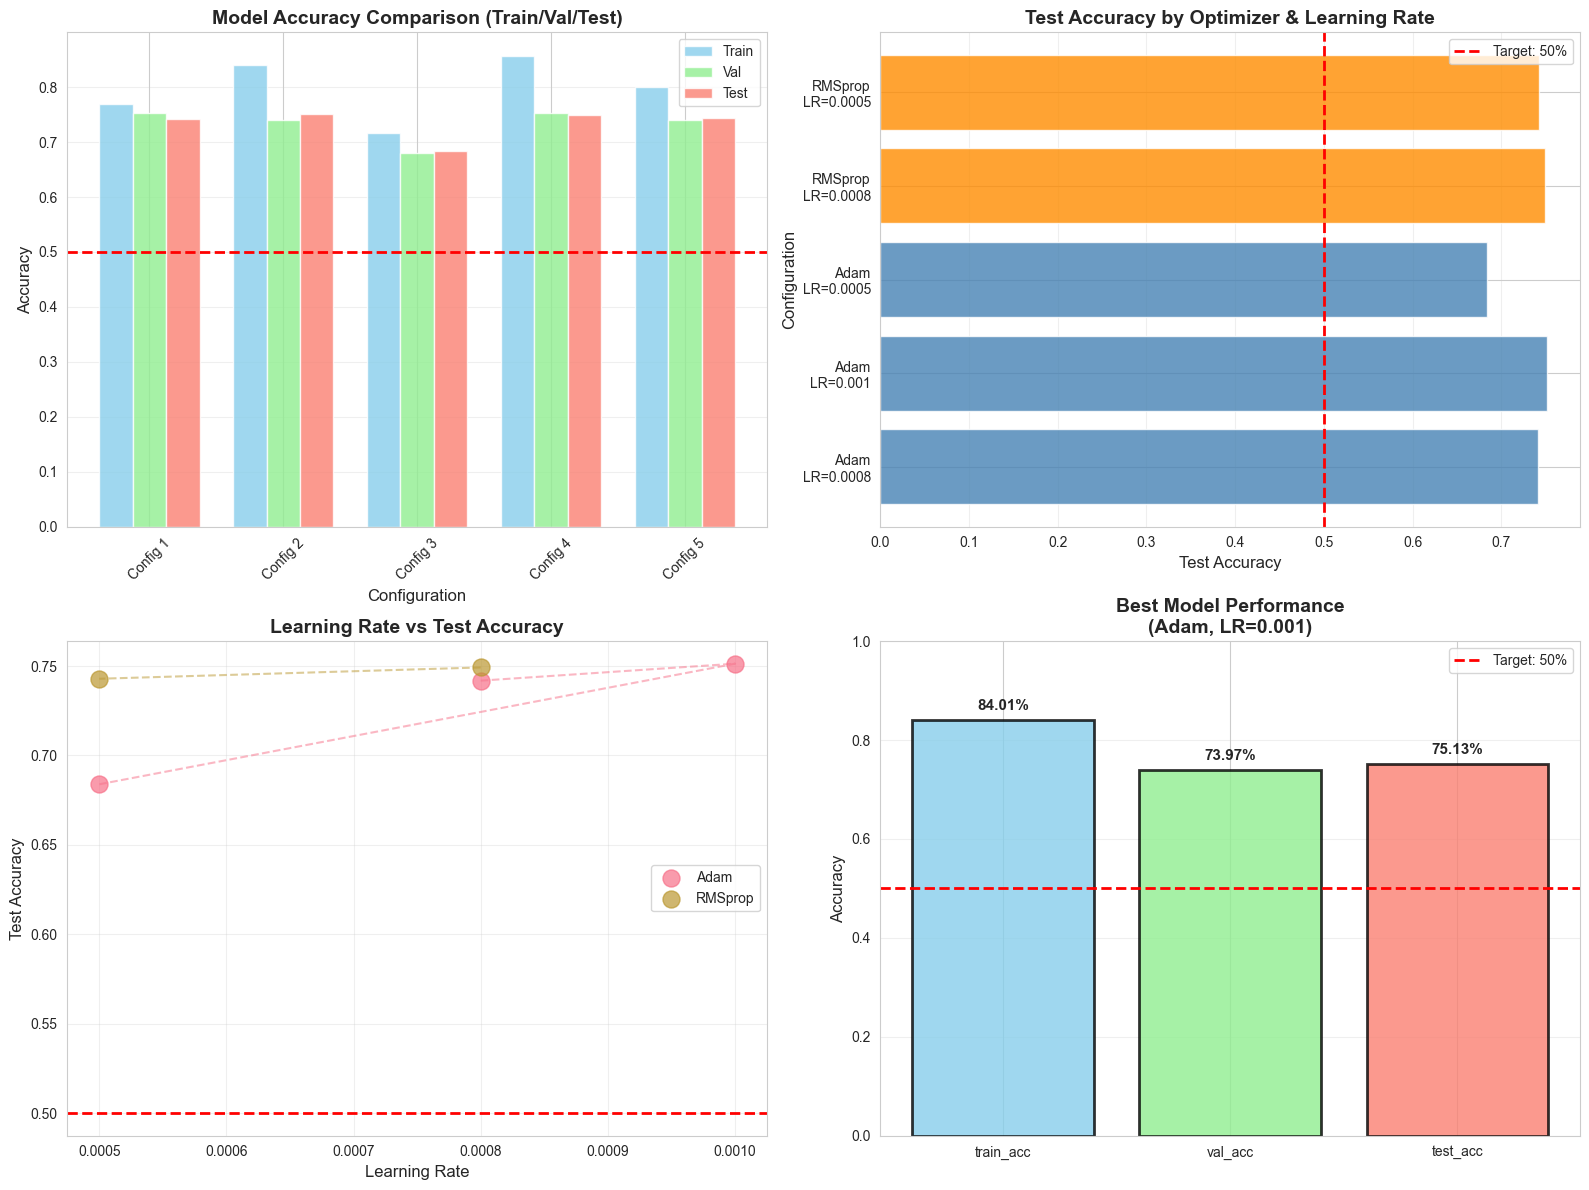


Best configuration: Config 2
Test Accuracy: 75.13%


In [27]:
# Compare model performances across different hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Train/Val/Test accuracy comparison
x_pos = np.arange(len(results_df))
width = 0.25
axes[0, 0].bar(x_pos - width, results_df['train_acc'], width, label='Train', color='skyblue', alpha=0.8)
axes[0, 0].bar(x_pos, results_df['val_acc'], width, label='Val', color='lightgreen', alpha=0.8)
axes[0, 0].bar(x_pos + width, results_df['test_acc'], width, label='Test', color='salmon', alpha=0.8)
axes[0, 0].set_xlabel('Configuration', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy Comparison (Train/Val/Test)', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'Config {i+1}' for i in range(len(results_df))], rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=0.50, color='red', linestyle='--', linewidth=2, label='Target: 50%')

# 2. Test accuracy by optimizer and learning rate
results_df['config_label'] = results_df.apply(lambda r: f"{r['optimizer']}\nLR={r['lr']}", axis=1)
colors_opt = ['steelblue' if opt == 'Adam' else 'darkorange' for opt in results_df['optimizer']]
axes[0, 1].barh(results_df['config_label'], results_df['test_acc'], color=colors_opt, alpha=0.8)
axes[0, 1].set_xlabel('Test Accuracy', fontsize=12)
axes[0, 1].set_ylabel('Configuration', fontsize=12)
axes[0, 1].set_title('Test Accuracy by Optimizer & Learning Rate', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0.50, color='red', linestyle='--', linewidth=2, label='Target: 50%')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Learning rate vs test accuracy scatter
for opt in results_df['optimizer'].unique():
    opt_data = results_df[results_df['optimizer'] == opt]
    axes[1, 0].scatter(opt_data['lr'], opt_data['test_acc'], s=150, alpha=0.7, label=opt)
    axes[1, 0].plot(opt_data['lr'], opt_data['test_acc'], alpha=0.5, linestyle='--')
axes[1, 0].set_xlabel('Learning Rate', fontsize=12)
axes[1, 0].set_ylabel('Test Accuracy', fontsize=12)
axes[1, 0].set_title('Learning Rate vs Test Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0.50, color='red', linestyle='--', linewidth=2)

# 4. Best model highlight
best_config = results_df.loc[results_df['test_acc'].idxmax()]
metrics = ['train_acc', 'val_acc', 'test_acc']
values = [best_config[m] for m in metrics]
colors_metrics = ['skyblue', 'lightgreen', 'salmon']
axes[1, 1].bar(metrics, values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_title(f'Best Model Performance\n({best_config["optimizer"]}, LR={best_config["lr"]})', 
                      fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].axhline(y=0.50, color='red', linestyle='--', linewidth=2, label='Target: 50%')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (metric, val) in enumerate(zip(metrics, values)):
    axes[1, 1].text(i, val + 0.02, f'{val:.2%}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nBest configuration: Config {best_config['config']}")
print(f"Test Accuracy: {best_config['test_acc']:.2%}")

In [28]:
# Artifact paths for this run
ARTIFACTS_DIR = r'd:\CodingRelated\Codes.Ams\ANNFINAL\artifacts_run5'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Persist tokenizer and label encoder classes
with open(os.path.join(ARTIFACTS_DIR, 'tokenizer_word_index.json'), 'w', encoding='utf-8') as f:
    json.dump(tokenizer.word_to_index, f)
np.save(os.path.join(ARTIFACTS_DIR, 'label_classes.npy'), label_encoder.classes_)

print(f"Artifacts directory: {ARTIFACTS_DIR}")

Artifacts directory: d:\CodingRelated\Codes.Ams\ANNFINAL\artifacts_run5


# 13. Model Evaluation

In [29]:
# Load best model (match training embed_dim)
best_model = LSTMClassifier(VOCAB_SIZE, embed_dim=200, num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

# Get predictions
X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
with torch.no_grad():
    y_pred = best_model(X_test_tensor).cpu().numpy()

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

print(f"Loaded best model from: model_{best_idx + 1}.pt")

Loaded best model from: model_2.pt


In [30]:
# Confusion matrix - save and print
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

cm_path = os.path.join(ARTIFACTS_DIR, 'confusion_matrix.csv')
cm_df.to_csv(cm_path)

print("\nConfusion Matrix:")
print(cm)
print(f"\nSaved confusion matrix to: {cm_path}")
print(f"\nAccuracy per class:")
for i, class_name in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.2%}")


Confusion Matrix:
[[69  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 63  0  0  0  0  0  0  0  0  0]
 [ 0  0 52  1  1  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  1 37  0  1  0  0  0  0  0  0  0  0  0  2  0  1  0]
 [ 0  0  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [34  0  0  0  0  0 15  0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 49  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  1  0  0  0  0 20  0  0  0  0  5  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  8  0  0 45  0  0  0  0  0  0  0  5  0  2]
 [ 0  0  0  0  0  0  0  0  0  0 37  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  0 63  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0 28  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0 28  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 76  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  

## 13.1 Detailed Performance Visualizations

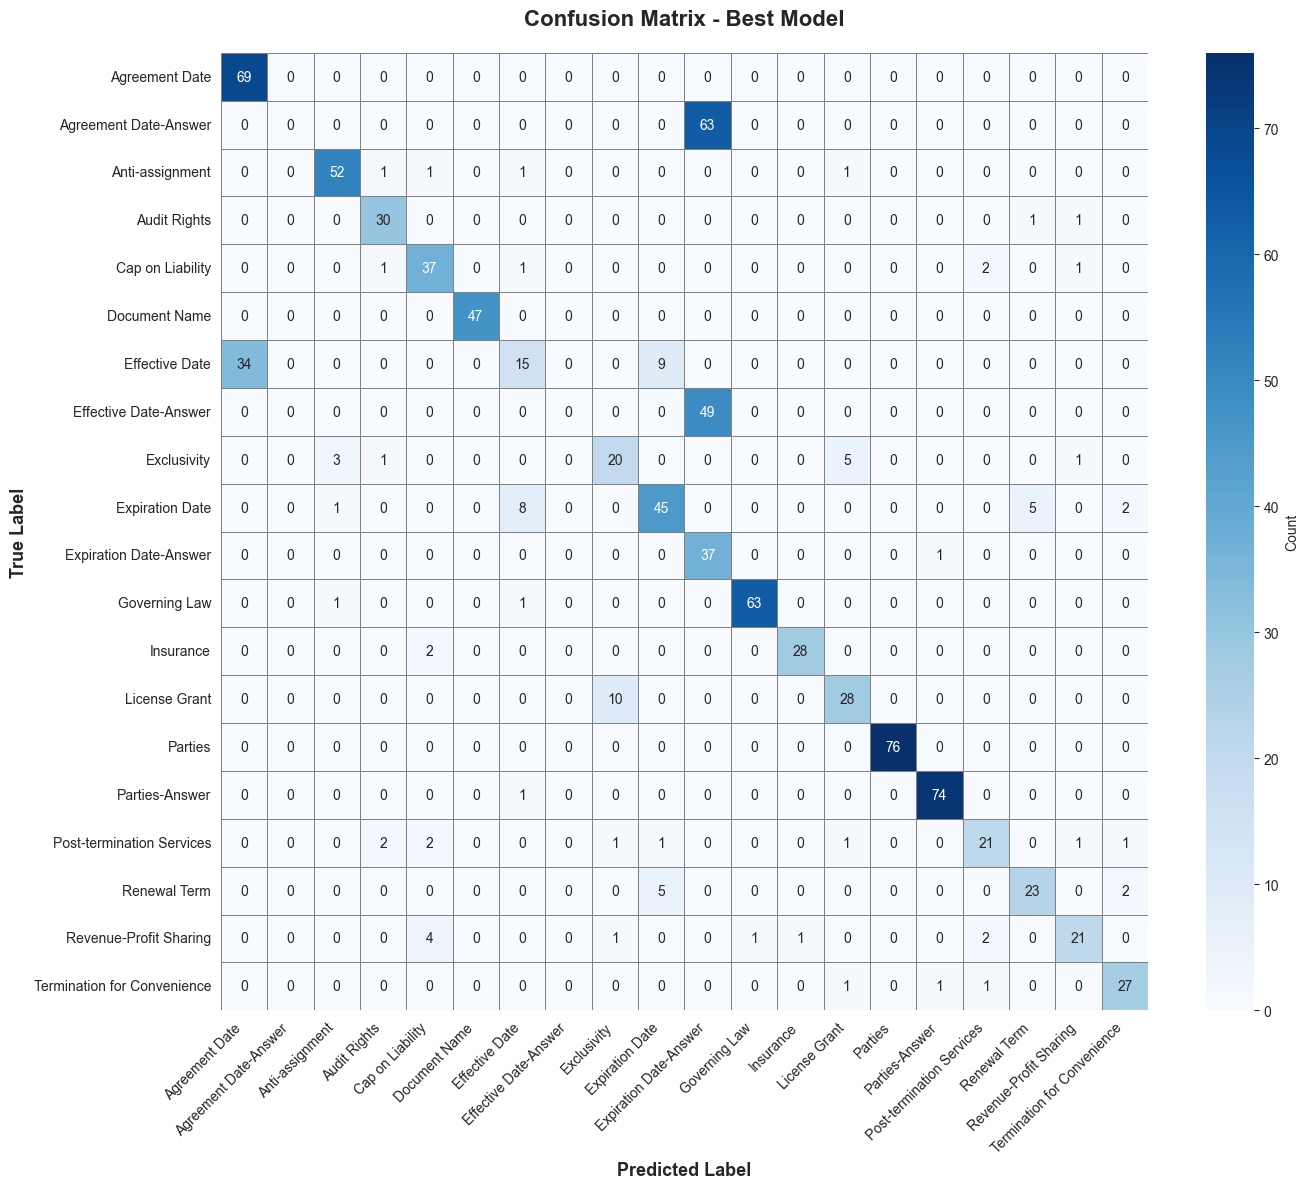

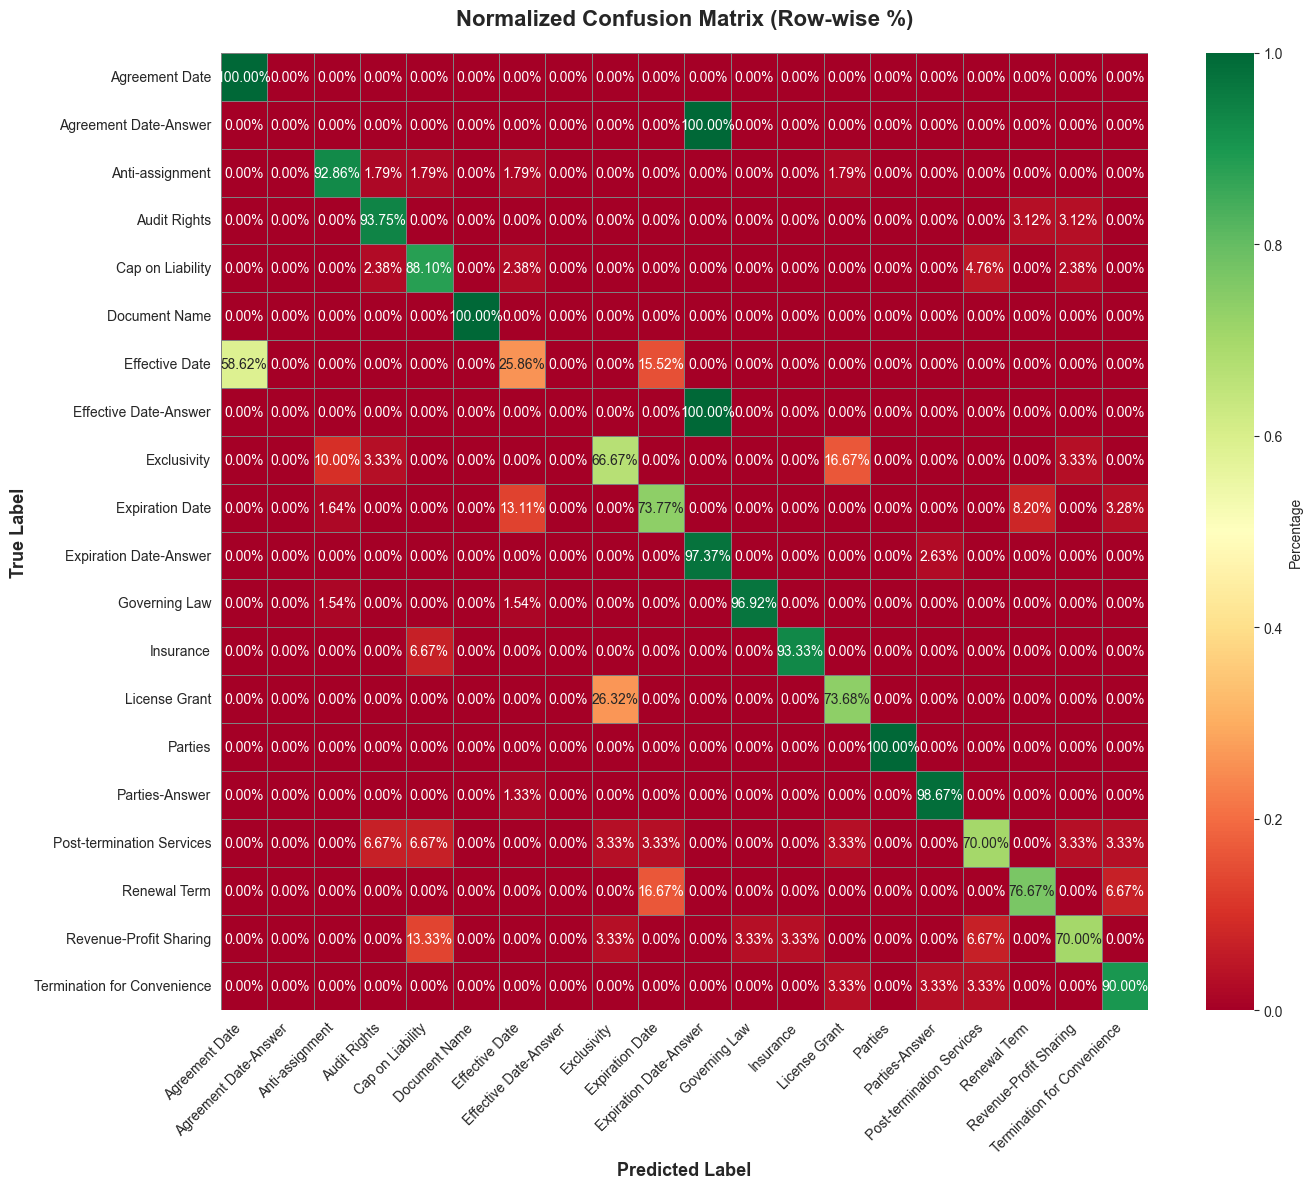

In [31]:
# Enhanced confusion matrix heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Confusion Matrix - Best Model', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Percentage'},
            linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Normalized Confusion Matrix (Row-wise %)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\heral\AppData\Local\Temp\ipykernel_17748\3778051013.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(classes, rotation=45, ha='right')


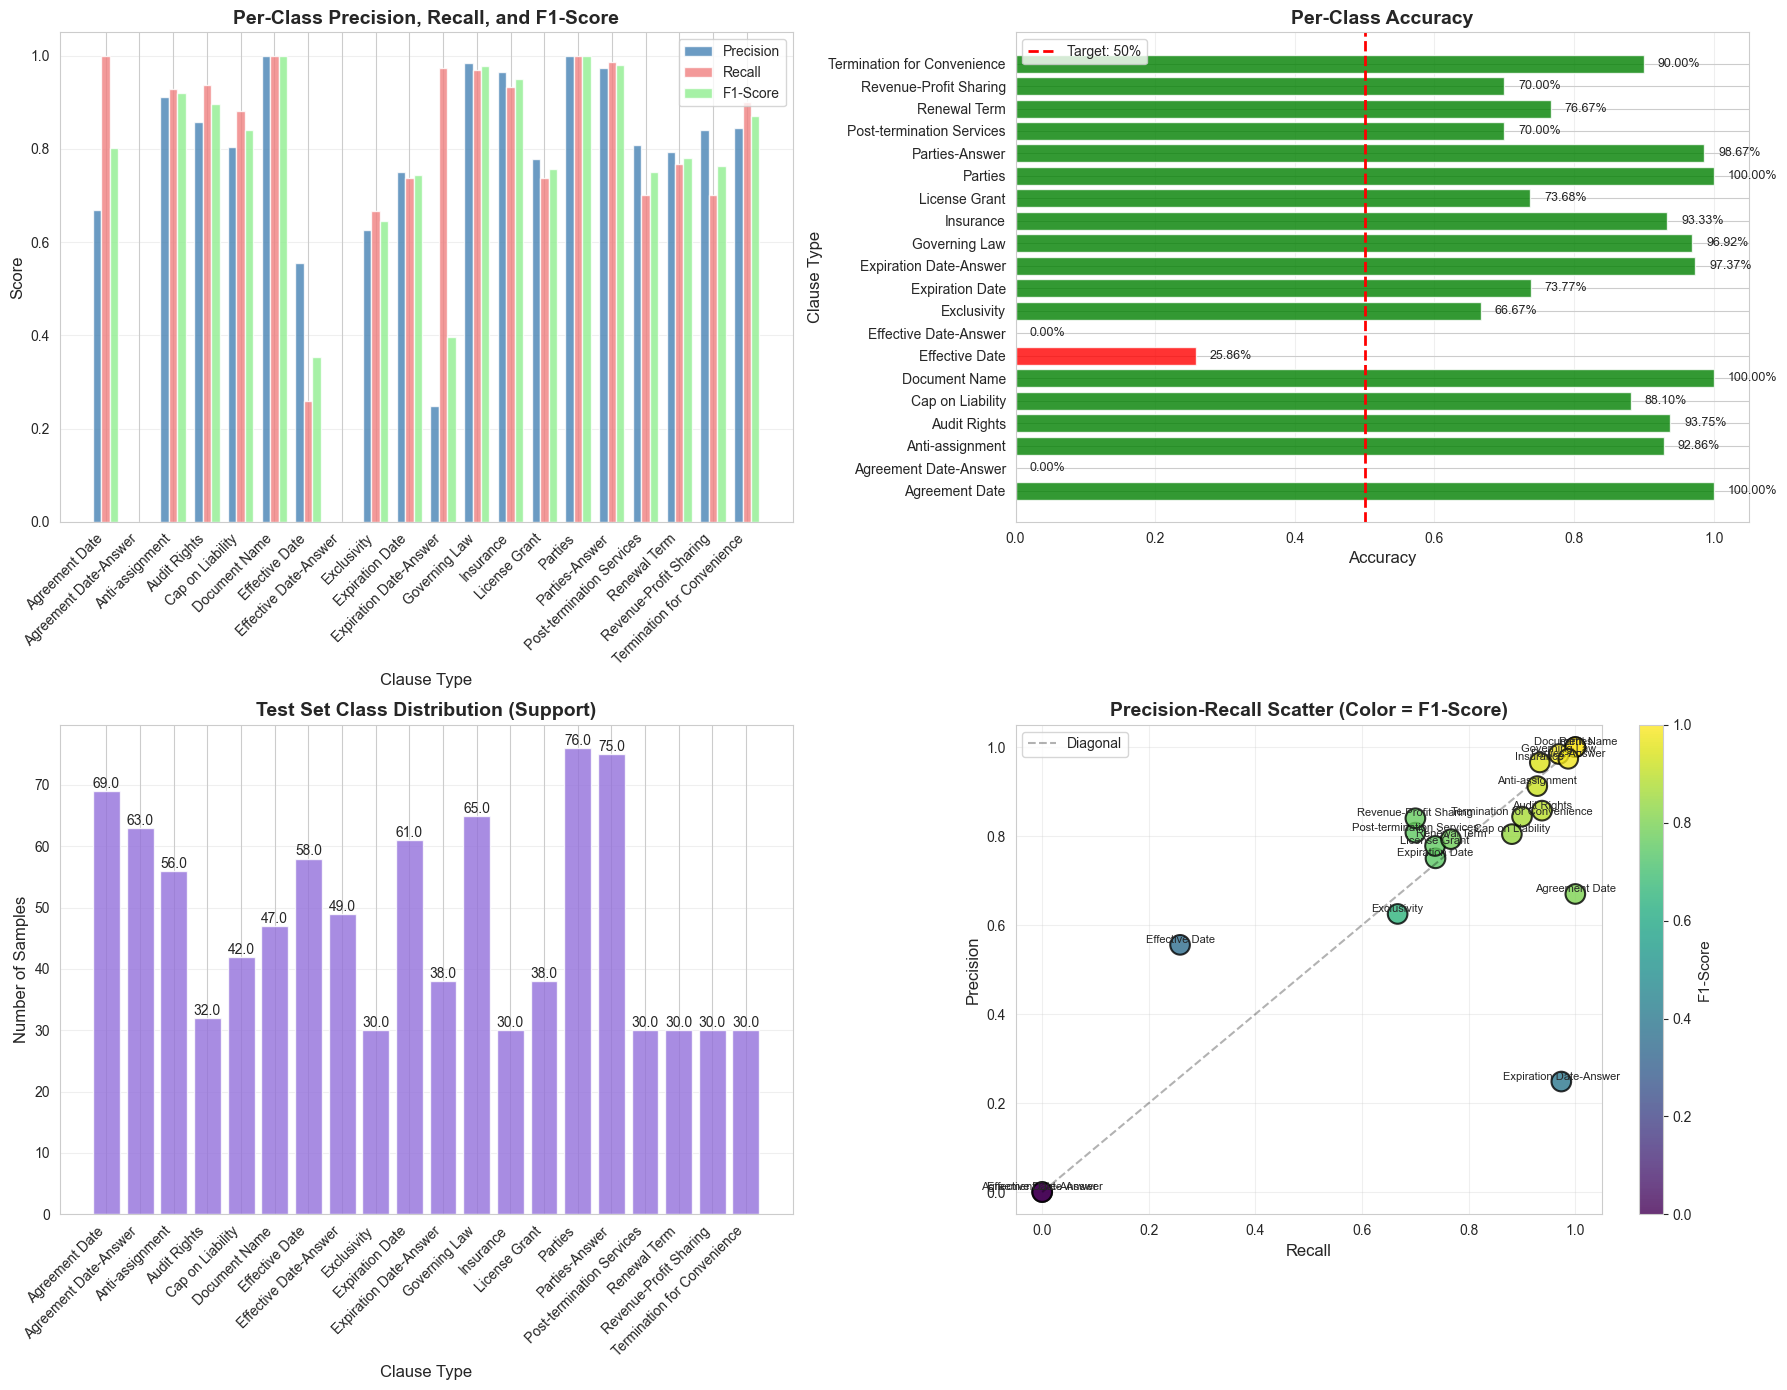


OVERALL METRICS
Macro Avg Precision: 0.7204
Macro Avg Recall: 0.7538
Macro Avg F1-Score: 0.7212
Weighted Avg F1-Score: 0.7200
Overall Accuracy: 0.7513


In [32]:
# Per-class metrics visualization
report_dict = classification_report(y_true_classes, y_pred_classes, 
                                   target_names=label_encoder.classes_, 
                                   output_dict=True, zero_division=0)

# Extract per-class metrics
classes = label_encoder.classes_
precision_scores = [report_dict[cls]['precision'] for cls in classes]
recall_scores = [report_dict[cls]['recall'] for cls in classes]
f1_scores = [report_dict[cls]['f1-score'] for cls in classes]

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Precision, Recall, F1 comparison
x_pos = np.arange(len(classes))
width = 0.25
axes[0, 0].bar(x_pos - width, precision_scores, width, label='Precision', color='steelblue', alpha=0.8)
axes[0, 0].bar(x_pos, recall_scores, width, label='Recall', color='lightcoral', alpha=0.8)
axes[0, 0].bar(x_pos + width, f1_scores, width, label='F1-Score', color='lightgreen', alpha=0.8)
axes[0, 0].set_xlabel('Clause Type', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Per-Class Precision, Recall, and F1-Score', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(classes, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.05])

# 2. Per-class accuracy from confusion matrix
class_accuracies = [cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0 for i in range(len(classes))]
colors_acc = ['green' if acc >= 0.5 else 'orange' if acc >= 0.3 else 'red' for acc in class_accuracies]
axes[0, 1].barh(classes, class_accuracies, color=colors_acc, alpha=0.8)
axes[0, 1].set_xlabel('Accuracy', fontsize=12)
axes[0, 1].set_ylabel('Clause Type', fontsize=12)
axes[0, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Target: 50%')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, (cls, acc) in enumerate(zip(classes, class_accuracies)):
    axes[0, 1].text(acc + 0.02, i, f'{acc:.2%}', va='center', fontsize=9)

# 3. Support (number of samples per class in test set)
support = [report_dict[cls]['support'] for cls in classes]
axes[1, 0].bar(classes, support, color='mediumpurple', alpha=0.8)
axes[1, 0].set_xlabel('Clause Type', fontsize=12)
axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
axes[1, 0].set_title('Test Set Class Distribution (Support)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(classes, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, (cls, sup) in enumerate(zip(classes, support)):
    axes[1, 0].text(i, sup + 0.5, str(sup), ha='center', fontsize=10)

# 4. Precision-Recall tradeoff scatter
axes[1, 1].scatter(recall_scores, precision_scores, s=200, c=f1_scores, 
                   cmap='viridis', alpha=0.8, edgecolors='black', linewidth=1.5)
for i, cls in enumerate(classes):
    axes[1, 1].annotate(cls, (recall_scores[i], precision_scores[i]), 
                        fontsize=8, ha='center', va='bottom')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_ylabel('Precision', fontsize=12)
axes[1, 1].set_title('Precision-Recall Scatter (Color = F1-Score)', fontsize=14, fontweight='bold')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Diagonal')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('F1-Score', fontsize=11)

plt.tight_layout()
plt.show()

# Print overall metrics
print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
print(f"Macro Avg Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"Macro Avg Recall: {report_dict['macro avg']['recall']:.4f}")
print(f"Macro Avg F1-Score: {report_dict['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-Score: {report_dict['weighted avg']['f1-score']:.4f}")
print(f"Overall Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")

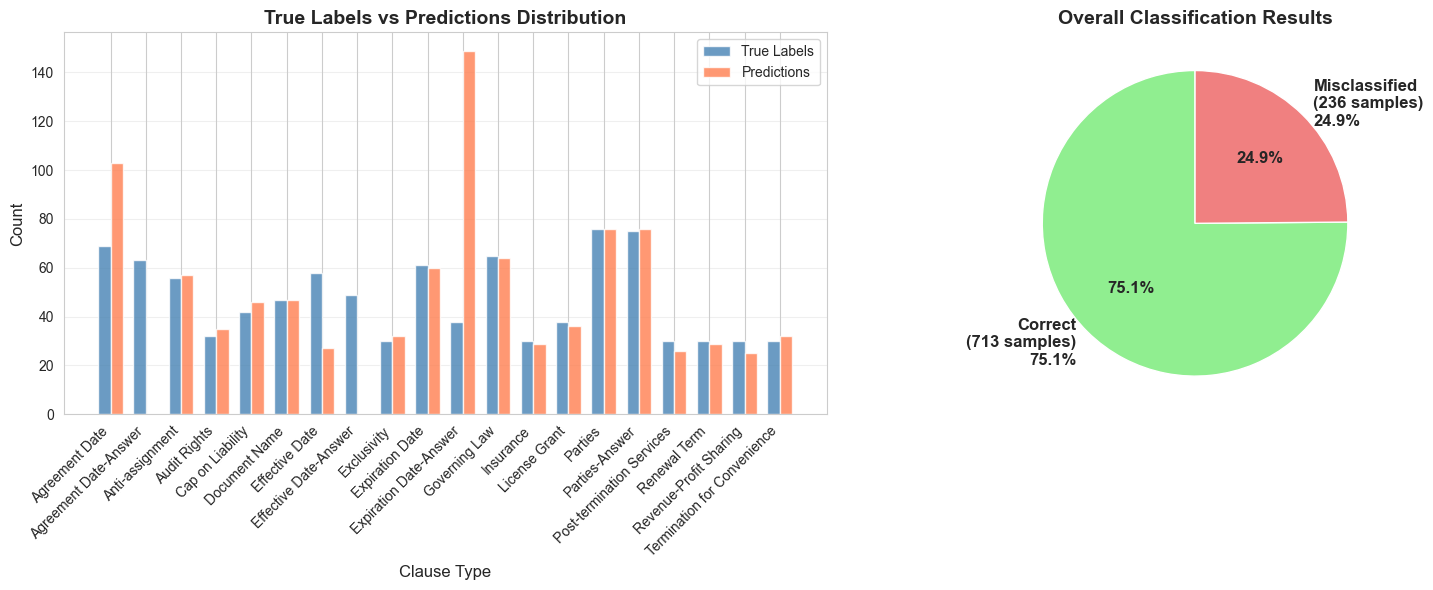


Classification Summary:
Total samples: 949
Correctly classified: 713 (75.13%)
Misclassified: 236 (24.87%)


In [33]:
# Prediction distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True vs Predicted distribution comparison
true_counts = pd.Series(y_true_classes).value_counts().sort_index()
pred_counts = pd.Series(y_pred_classes).value_counts().sort_index()

# Ensure both have same index
all_classes = sorted(set(y_true_classes) | set(y_pred_classes))
true_counts = true_counts.reindex(all_classes, fill_value=0)
pred_counts = pred_counts.reindex(all_classes, fill_value=0)

x_pos = np.arange(len(all_classes))
width = 0.35
class_names = [label_encoder.classes_[i] for i in all_classes]

axes[0].bar(x_pos - width/2, true_counts.values, width, label='True Labels', 
            color='steelblue', alpha=0.8)
axes[0].bar(x_pos + width/2, pred_counts.values, width, label='Predictions', 
            color='coral', alpha=0.8)
axes[0].set_xlabel('Clause Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('True Labels vs Predictions Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Misclassification analysis
correct = (y_true_classes == y_pred_classes).sum()
incorrect = len(y_true_classes) - correct
pie_data = [correct, incorrect]
pie_labels = [f'Correct\n({correct} samples)\n{correct/len(y_true_classes):.1%}',
f'Misclassified\n({incorrect} samples)\n{incorrect/len(y_true_classes):.1%}']
colors_pie = ['lightgreen', 'lightcoral']
axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90, 
            colors=colors_pie, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Overall Classification Results', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClassification Summary:")
print(f"Total samples: {len(y_true_classes)}")
print(f"Correctly classified: {correct} ({correct/len(y_true_classes):.2%})")
print(f"Misclassified: {incorrect} ({incorrect/len(y_true_classes):.2%})")

In [34]:
# Classification report - save to artifacts
print("\nClassification Report:")
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=label_encoder.classes_,
    output_dict=True,
    zero_division=0,
)
report_df = pd.DataFrame(report).T
print(report_df)

report_path = os.path.join(ARTIFACTS_DIR, 'classification_report.csv')
report_df.to_csv(report_path)
print(f"\nSaved classification report to: {report_path}")


Classification Report:
                             precision    recall  f1-score     support
Agreement Date                0.669903  1.000000  0.802326   69.000000
Agreement Date-Answer         0.000000  0.000000  0.000000   63.000000
Anti-assignment               0.912281  0.928571  0.920354   56.000000
Audit Rights                  0.857143  0.937500  0.895522   32.000000
Cap on Liability              0.804348  0.880952  0.840909   42.000000
Document Name                 1.000000  1.000000  1.000000   47.000000
Effective Date                0.555556  0.258621  0.352941   58.000000
Effective Date-Answer         0.000000  0.000000  0.000000   49.000000
Exclusivity                   0.625000  0.666667  0.645161   30.000000
Expiration Date               0.750000  0.737705  0.743802   61.000000
Expiration Date-Answer        0.248322  0.973684  0.395722   38.000000
Governing Law                 0.984375  0.969231  0.976744   65.000000
Insurance                     0.965517  0.933333  0.9